In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from utils import ReadDatasets, normalized_stft
from data_augmentation import TransientMaker

In [2]:
dataset = ReadDatasets()

In [3]:
gt_fids, ppm, t = dataset.read_h5_sample_track_1('../sample_data.h5')
transientmkr = TransientMaker(fids=gt_fids[:1,:,:],t=t,n_transients=160)
transientmkr.add_random_amplitude_noise(noise_level_base=6,noise_level_scan_var=2)
aug_fids = transientmkr.fids

In [4]:
dwelltime = t[0,1]-t[0,0]
bandwidth = 1/dwelltime

spectra_gt_fids = np.fft.fftshift(np.fft.fft(gt_fids,n=gt_fids.shape[1],axis = 1), axes = 1)
spectra_gt_diff = spectra_gt_fids[:,:,1] - spectra_gt_fids[:,:,0]
freq = np.flip(np.fft.fftshift(np.fft.fftfreq(gt_fids.shape[1], d = dwelltime)))
#to get ppm axis
idx_min = np.real(spectra_gt_diff[0,:]).argmin()
idx_max = np.real(spectra_gt_diff[0,:]).argmax()
#p = a*f + b
#not really necessary to flip to find a and b since freq and ppm agree, but we use it to enphasize the flip
#and also so np.flip(ppm)[0,idx_max] = 4.7 ppm, np.flip(ppm)[0,idx_min] = 2 ppm
#and np.flip(freq)[idx_max] = 216 Hz, and np.flip(freq)[idx_min] = -127 Hz, which agree with visual observation
a = (np.flip(ppm)[0,idx_max] - np.flip(ppm)[0,idx_min])/(np.flip(freq)[idx_max]-np.flip(freq)[idx_min])
b = np.flip(ppm)[0,idx_max] - a*np.flip(freq)[idx_max]

In [5]:
stft_coefficients_onesided_norm = normalized_stft(fid=np.mean(aug_fids[0,:,1,:]-aug_fids[0,:,0,:],axis=-1), fs=bandwidth, larmorfreq=127.73, window_size=600, hop_size=12, window='hann')

In [6]:
f_aux, t_aux, stft_coefficients_aux = signal.stft(np.mean(aug_fids[0,:,1,:]-aug_fids[0,:,0,:],axis=-1), fs=bandwidth, nperseg=600, window='hann', noverlap=(600-12),return_onesided=False)
f_gab = np.concatenate([np.split(f_aux, 2)[1],
                        np.split(f_aux, 2)[0]])
stft_coefficients_ordered_aux = np.concatenate([np.split(stft_coefficients_aux, 2)[1],
                                                np.split(stft_coefficients_aux, 2)[0]])
stft_coefficients_ordered_gab = np.flip(stft_coefficients_ordered_aux, axis=0)

In [7]:
t_aux

array([0.   , 0.006, 0.012, 0.018, 0.024, 0.03 , 0.036, 0.042, 0.048,
       0.054, 0.06 , 0.066, 0.072, 0.078, 0.084, 0.09 , 0.096, 0.102,
       0.108, 0.114, 0.12 , 0.126, 0.132, 0.138, 0.144, 0.15 , 0.156,
       0.162, 0.168, 0.174, 0.18 , 0.186, 0.192, 0.198, 0.204, 0.21 ,
       0.216, 0.222, 0.228, 0.234, 0.24 , 0.246, 0.252, 0.258, 0.264,
       0.27 , 0.276, 0.282, 0.288, 0.294, 0.3  , 0.306, 0.312, 0.318,
       0.324, 0.33 , 0.336, 0.342, 0.348, 0.354, 0.36 , 0.366, 0.372,
       0.378, 0.384, 0.39 , 0.396, 0.402, 0.408, 0.414, 0.42 , 0.426,
       0.432, 0.438, 0.444, 0.45 , 0.456, 0.462, 0.468, 0.474, 0.48 ,
       0.486, 0.492, 0.498, 0.504, 0.51 , 0.516, 0.522, 0.528, 0.534,
       0.54 , 0.546, 0.552, 0.558, 0.564, 0.57 , 0.576, 0.582, 0.588,
       0.594, 0.6  , 0.606, 0.612, 0.618, 0.624, 0.63 , 0.636, 0.642,
       0.648, 0.654, 0.66 , 0.666, 0.672, 0.678, 0.684, 0.69 , 0.696,
       0.702, 0.708, 0.714, 0.72 , 0.726, 0.732, 0.738, 0.744, 0.75 ,
       0.756, 0.762,

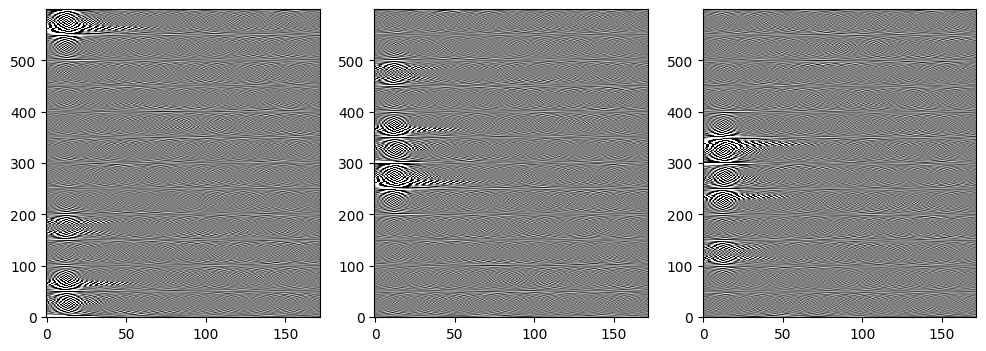

In [8]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
ax[0].imshow(np.real(stft_coefficients_aux),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[1].imshow(np.real(stft_coefficients_ordered_aux),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[2].imshow(np.real(stft_coefficients_ordered_gab),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')

In [9]:
print(np.real(stft_coefficients_ordered_gab).max())
print(np.real(stft_coefficients_ordered_gab).min())
print(np.abs(stft_coefficients_ordered_gab).max())

10.060382308335676
-9.991622882506306
10.382381563224687


In [10]:
def get_normalized_spectrogram(
    fids, bandwidth, window, mfft, hop, norm, correct_time, a, b
):
    """
    Get normalized spectrogram of fids
    Inputs:
    fids: np array (N, T) (N - number of different transients, T - number of samples in each FID)
    bandwidth: sampling frequency used for the fids (param of ShortTimeFFT)
    window: np array (W); window for the STFT (param of ShortTimeFFT)
    mfft: int; the amount of frequencies in the STFT (param of ShortTimeFFT)
    hop: int; the window step (param of ShortTimeFFT)
    norm: str; if 'm1p1' - norm between [-1,1], if 'zscore' - norm zscore, if 'minmax' - norm beteen (-1,1), else norm abs
    correct_time: if True, time is limited between 0 and 1s
    a: float, slope of the transformation between freq and ppm
    b: float, linear coef. of the transformation between freq and ppm
    Outputs:
    spgram: np array (N, mfft, nt) (nt - number of time windows)
    freq_spect: np array (mfft,), frequencies in spgram
    ppm_spect: np array (mfft,), frequencies in spgram converted to ppm
    t_spect: np array (nt,), time smaples in spgram
    """
    qntty = fids.shape[0]
    SFT = signal.ShortTimeFFT(
        win=window,
        hop=hop,
        fs=bandwidth,
        mfft=mfft,
        scale_to="magnitude",
        fft_mode="centered",
    )
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fids.shape[1])
    # array with spectrograms
    spgram = []
    for i in range(qntty):
        aux = SFT.stft(fids[i, :])
        print(np.max(np.real(aux)))
        print(np.min(np.real(aux)))
        print(np.max(np.abs(aux)))
        spgram.append((aux/np.max(np.abs(aux))))
    spgram = np.array(spgram)
    # frequency array
    freq_spect = np.flip(np.linspace(f_lo, f_hi, mfft))
    # ppm array
    ppm_spect = a * freq_spect + b
    # time array
    t_spect = np.linspace(t_lo, t_hi, spgram.shape[2])

    if correct_time == True:
        zero_idx = np.abs(t_spect - 0.0).argmin()
        one_idx = np.abs(t_spect - 1.0).argmin()
        t_spect = t_spect[zero_idx:one_idx]
        spgram = spgram[:, :, zero_idx:one_idx]

    return spgram, freq_spect, ppm_spect, t_spect

In [11]:
mfft_ = 600
window_ = signal.windows.hann(mfft_,sym=True)
hop_ = 12
norm_ = 'abs'
stft_coefficients, freq_spect, ppm_spect, t_spect = get_normalized_spectrogram(fids=np.mean(aug_fids[:1,:,1,:]-aug_fids[:1,:,0,:],axis=-1), bandwidth=bandwidth, window=window_, mfft=mfft_, hop=hop_, norm=norm_, correct_time=True, a=a, b=b)

10.069228163892983
-9.994817323433882
10.394064152345832


In [12]:
t_spect

array([6.57534247e-04, 6.68493151e-03, 1.27123288e-02, 1.87397260e-02,
       2.47671233e-02, 3.07945205e-02, 3.68219178e-02, 4.28493151e-02,
       4.88767123e-02, 5.49041096e-02, 6.09315068e-02, 6.69589041e-02,
       7.29863014e-02, 7.90136986e-02, 8.50410959e-02, 9.10684932e-02,
       9.70958904e-02, 1.03123288e-01, 1.09150685e-01, 1.15178082e-01,
       1.21205479e-01, 1.27232877e-01, 1.33260274e-01, 1.39287671e-01,
       1.45315068e-01, 1.51342466e-01, 1.57369863e-01, 1.63397260e-01,
       1.69424658e-01, 1.75452055e-01, 1.81479452e-01, 1.87506849e-01,
       1.93534247e-01, 1.99561644e-01, 2.05589041e-01, 2.11616438e-01,
       2.17643836e-01, 2.23671233e-01, 2.29698630e-01, 2.35726027e-01,
       2.41753425e-01, 2.47780822e-01, 2.53808219e-01, 2.59835616e-01,
       2.65863014e-01, 2.71890411e-01, 2.77917808e-01, 2.83945205e-01,
       2.89972603e-01, 2.96000000e-01, 3.02027397e-01, 3.08054795e-01,
       3.14082192e-01, 3.20109589e-01, 3.26136986e-01, 3.32164384e-01,
      

In [13]:
f_gab

array([-1000.        ,  -996.66666667,  -993.33333333,  -990.        ,
        -986.66666667,  -983.33333333,  -980.        ,  -976.66666667,
        -973.33333333,  -970.        ,  -966.66666667,  -963.33333333,
        -960.        ,  -956.66666667,  -953.33333333,  -950.        ,
        -946.66666667,  -943.33333333,  -940.        ,  -936.66666667,
        -933.33333333,  -930.        ,  -926.66666667,  -923.33333333,
        -920.        ,  -916.66666667,  -913.33333333,  -910.        ,
        -906.66666667,  -903.33333333,  -900.        ,  -896.66666667,
        -893.33333333,  -890.        ,  -886.66666667,  -883.33333333,
        -880.        ,  -876.66666667,  -873.33333333,  -870.        ,
        -866.66666667,  -863.33333333,  -860.        ,  -856.66666667,
        -853.33333333,  -850.        ,  -846.66666667,  -843.33333333,
        -840.        ,  -836.66666667,  -833.33333333,  -830.        ,
        -826.66666667,  -823.33333333,  -820.        ,  -816.66666667,
      

In [14]:
freq_spect

array([  996.66666667,   993.33333333,   990.        ,   986.66666667,
         983.33333333,   980.        ,   976.66666667,   973.33333333,
         970.        ,   966.66666667,   963.33333333,   960.        ,
         956.66666667,   953.33333333,   950.        ,   946.66666667,
         943.33333333,   940.        ,   936.66666667,   933.33333333,
         930.        ,   926.66666667,   923.33333333,   920.        ,
         916.66666667,   913.33333333,   910.        ,   906.66666667,
         903.33333333,   900.        ,   896.66666667,   893.33333333,
         890.        ,   886.66666667,   883.33333333,   880.        ,
         876.66666667,   873.33333333,   870.        ,   866.66666667,
         863.33333333,   860.        ,   856.66666667,   853.33333333,
         850.        ,   846.66666667,   843.33333333,   840.        ,
         836.66666667,   833.33333333,   830.        ,   826.66666667,
         823.33333333,   820.        ,   816.66666667,   813.33333333,
      

In [15]:
print(stft_coefficients_onesided_norm.shape)
print(stft_coefficients.shape)

(600, 172)
(1, 600, 166)


Text(0.5, 1.0, 'Real(New)')

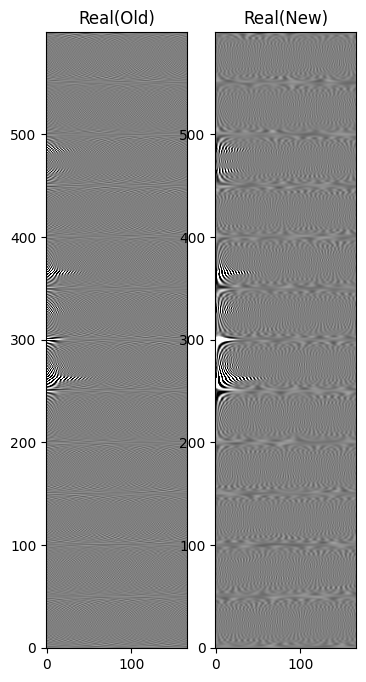

In [16]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
ax[0].imshow(np.flip(np.real(stft_coefficients_onesided_norm),axis=0)[:,6:],cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[1].imshow(np.real(stft_coefficients[0,:,:]),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[0].set_title('Real(Old)')
ax[1].set_title('Real(New)')

In [38]:
np.abs((np.flip(np.real(stft_coefficients_onesided_norm),axis=0)[:,6:]-np.real(stft_coefficients[0,:,:]))).max()

1.8508089339598452

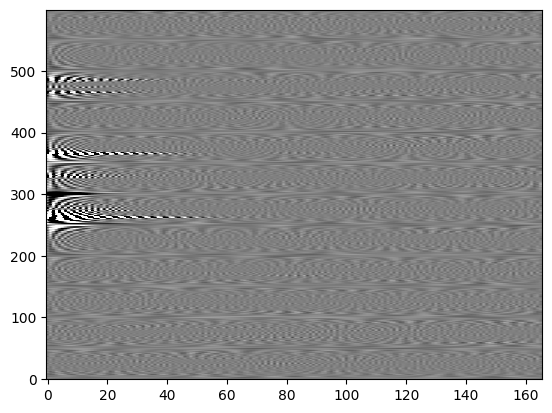

In [36]:
plt.imshow(np.flip(np.real(stft_coefficients_onesided_norm),axis=0)[:,6:]-np.real(stft_coefficients[0,:,:]),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')


Text(0.5, 1.0, 'Abs(New)')

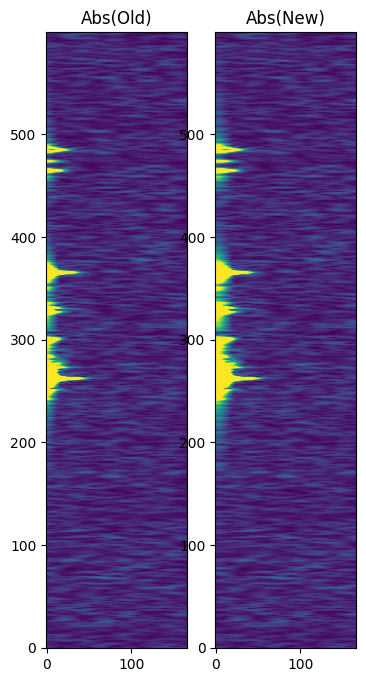

In [17]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
ax[0].imshow(np.flip(np.abs(stft_coefficients_onesided_norm),axis=0)[:,6:],cmap='viridis',vmax=0.04,origin='lower',aspect='auto')
ax[1].imshow(np.abs(stft_coefficients[0,:,:]),cmap='viridis',vmax=0.04,origin='lower',aspect='auto')
ax[0].set_title('Abs(Old)')
ax[1].set_title('Abs(New)')

Text(0.5, 1.0, 'Imag(New)')

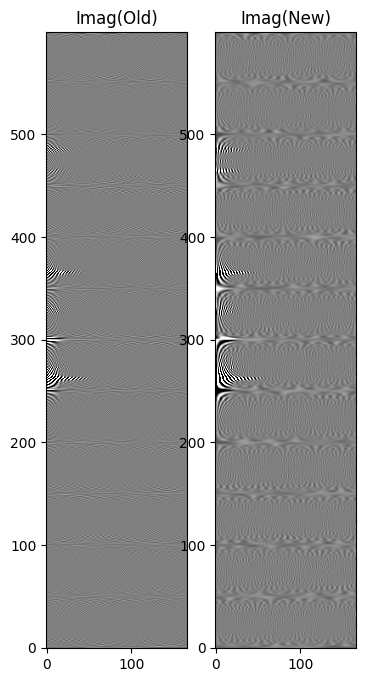

In [18]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
ax[0].imshow(np.flip(np.imag(stft_coefficients_onesided_norm),axis=0)[:,6:],cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[1].imshow(np.imag(stft_coefficients[0,:,:]),cmap='gray',vmin=-0.04,vmax=0.04,origin='lower',aspect='auto')
ax[0].set_title('Imag(Old)')
ax[1].set_title('Imag(New)')

Text(0.5, 1.0, 'Imag(New)')

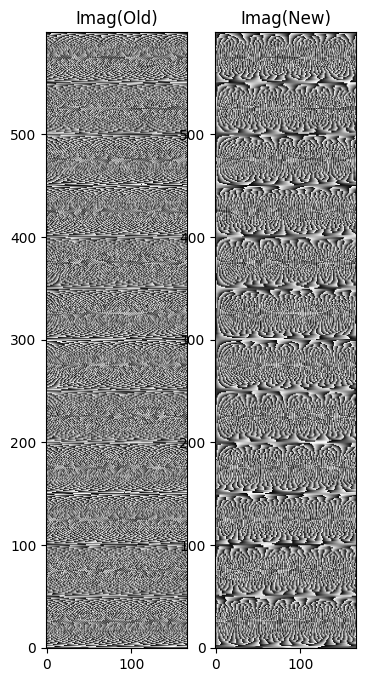

In [19]:
fig,ax = plt.subplots(1,2,figsize=(4,8))
ax[0].imshow(np.flip(np.angle(stft_coefficients_onesided_norm,deg=True),axis=0)[:,6:],cmap='gray',origin='lower',aspect='auto')
ax[1].imshow(np.angle(stft_coefficients[0,:,:],deg=True),cmap='gray',origin='lower',aspect='auto')
ax[0].set_title('Imag(Old)')
ax[1].set_title('Imag(New)')

In [32]:
test_wind = signal.get_window('hann',60)
test_wind_2 = signal.windows.hann(60,sym=True)

In [33]:
print(test_wind.shape)
print(test_wind_2.shape)

(60,)
(60,)


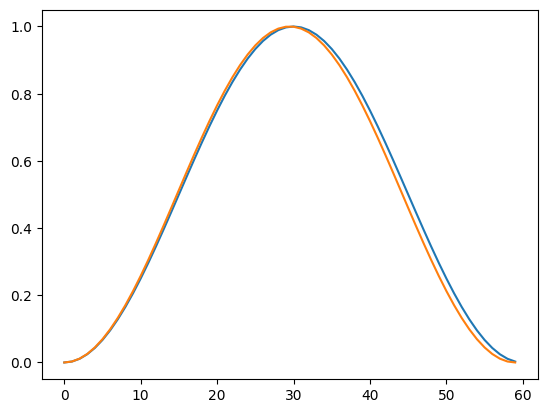

In [34]:
plt.plot(test_wind)
plt.plot(test_wind_2)